<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<h1 align="center"> MAT 400 Final Project: Analysis of U.S. Wildfire Cause from 1992 - 2015 </h1>  

<h3 align="center">Andrew Nolan</h3>

**Table of Contents:**
- [Project Overview](#intro)
- [Exploratory Data Analysis](#EDA)  
  - [Reading / Data Cleaning](#cleaning)
  - [Visualization](#visualization)
- [Modelling](#modeling)  
  - [Simple Tree](#tree)
  - [Bagging](#bagging)
  - [Random Forest](#forest)
  - [Boosting](#boosting)
  - [Extereme Gradient Boosting](#xgboost)
  - [Support Vector Machines](#SVM)
- [Disscusion / Conclusions](#wrap_up)  


## Project Overview <a class="anchor" id="intro"></a>

<p style="margin-top:5mm; text-align:center"> 
    Wildfires are an important natural hazard that threaten hunderds of thousands of lives and cause millions of dollars of propetry damage each year. We analyize a spatial database of wilfires infromation for the United States from 1992-2015, to investigate spatial, temporal and causation patterns. Entires into the database are collected from federal, state, and local fire authorities. Each entry into the database contains infromation such as date the fire was identified and contained, the area burned, and geolocates point for each fire. Additionally, each fire has a cause description of which there are thirteen classes ranging from arson to lightning. After inital exploratory data analysis we seek to train a number of statistical models to predict a fire cause class based on its size, duration, seasonality, and location. This represent a multiclass classification problem, for which trees, random forests, and boosting appear to be the most appropriate methods. Throughout this notebook we investigate these models and others, in order to find the best model for the task at hand. At this point this is an arbitray problem pursued for an academic purpose, but an efficent and effective model has the possibility to have a large societal impact. If the methodologies purpused here could have significant benefit to emergency service departments throughout the country. Additionaly, any relationships and or model trained at present will be intriguing points of comparision going into the future. The frequenecy and magnitude of fires are very likely to increase with a warming climate making this an even more important and pressing issue. 
</p>  

## Exploratory Data Analysis <a class="anchor" id="EDA"></a>

### Data Cleaning / Splitting <a class="anchor" id="cleaning"></a>  

In order to access the dataset we need to connect to the `SQL` database. Since the file fits in RAM we are going to disconnect from the database and leave the dataset in memoroy rather than running queries against the database to preform our analysis.

In [1]:
library(RSQLite)
suppressMessages(library(tidyverse))

connection <- dbConnect(SQLite(), './data/FPA_FOD_20170508.sqlite')
fires <- tbl(connection, "Fires") %>% collect()
dbDisconnect(connection)

We are given infromation about the date the fire was identified (`DISCOVERY_DATE`) and the date the fire was contained (`CONT_DATE`). From those two dates we can calculate the time that the fire burned. `DISCOVERY_DATE` & `CONT_DATE` are provided as julian dates, so when we difference the two numbers we are given the fire burn time in days. 

In [2]:
fires <- fires %>% mutate(BURN_TIME = CONT_DATE - DISCOVERY_DATE) 

###   Exploratory Data Analysis Visualization <a class="anchor" id="visualization"></a>

Before we start plotting, there are a few formatting commands to run to make the inline plots look all nice and pretty. 

In [3]:
IRdisplay::display_html('<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
</style>')

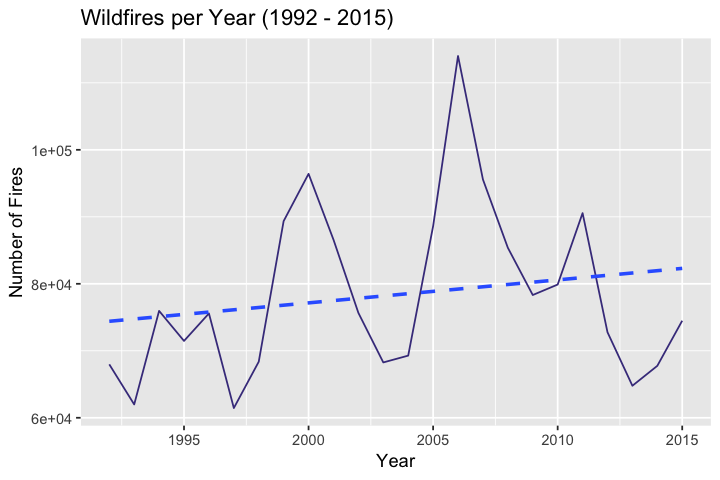

In [4]:
options(repr.plot.width=6, repr.plot.height=4, jupyter.plot_mimetypes = 'image/png')

fires %>% group_by(FIRE_YEAR) %>% summarize(n = n()) %>%
  ggplot(aes(x = FIRE_YEAR, y = n)) + geom_line(color = 'slateblue4') + 
  geom_smooth(method = 'lm', se = FALSE, linetype = 'dashed') + 
  labs(x = 'Year', y = 'Number of Fires', title = 'Wildfires per Year (1992 - 2015)')

**Fig 1.** Number of wild fire per year from 1992- 2015. There appears to be significant variability in the numbers of fires per year, though the variability appears to have a ~5 year period to it. This sub-decedal variability might be explained by large scale climatic forcing such as the Pacific Decadal Oscillation (PDO) though thats out of the scope of this project. Despite the variability there does appear to be positive trend in the number of fires per year. This increase in time is what we might expect in a warming climate, though we would a dataset with a longer timespan to really determine this relationship.

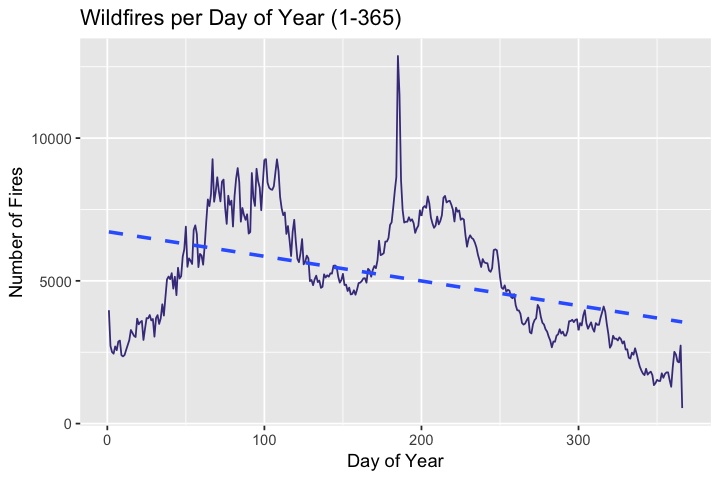

In [5]:
fires %>% group_by(DISCOVERY_DOY) %>% summarize(n = n()) %>%
  ggplot(aes(x = DISCOVERY_DOY, y = n)) + geom_line(color = 'slateblue4') + 
    geom_smooth(method = 'lm', se = FALSE, linetype = 'dashed') + 
      labs(x = 'Day of Year', y = 'Number of Fires', title = 'Wildfires per Day of Year (1-365)')

**Fig 2.** Number of wild fire per year calander day of year. A value of 1 would correspond to Jan 01 while a value of 365 would correspond to Dec 31st. In general there is a decrease in the number of fires per day throughout the year. There appears to be two seasonal maximums in the number of fires, the first occuring from 85 - 115 (~MAR) and the second from 180-220 (~June - July). The bimodal distribution is most likely due to different seasonal timings of the 'dry' season geographically throughout the U.S. 

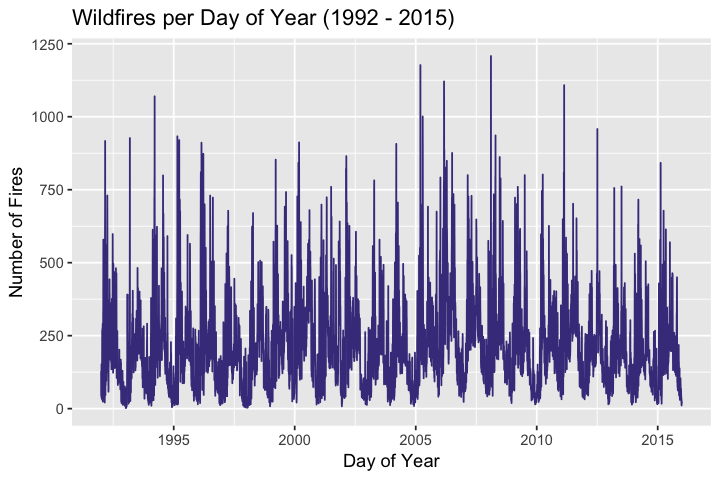

In [6]:
fires %>% mutate(date_ymd = as.Date(DISCOVERY_DATE - 2458598.5, origin = '2019-04-25')) %>%
  group_by(date_ymd) %>% summarise(n = n()) %>%  
    ggplot(aes(x = date_ymd, y = n)) + geom_line(color = 'slateblue4') + 
      labs(x = 'Day of Year', y = 'Number of Fires', title = 'Wildfires per Day of Year (1992 - 2015)')

**Fig 3.** Number of wildfires per day from 1992-2015. There appears to be a clear annual cyle in the number of fires supperimposed on the interannual variability. If were to do some spectral analysis on the data same we could asses the variability in a more complete way, but this is not within the scope of the project

In [7]:
fire_count <- fires %>% group_by(STAT_CAUSE_DESCR) %>% 
  summarize(n = n()) %>%
  ggplot(aes( x = reorder(STAT_CAUSE_DESCR, n), y = n)) + geom_bar(stat='identity', fill='slateblue4') + 
  coord_flip() + labs( x= '', y = 'Number of Fires', title = 'Count') + 
    ggsave("./figures/fire_count.png", width = 20, height = 10, units = "cm", dpi = 320)
burn_acres <- fires %>% group_by(STAT_CAUSE_DESCR) %>%
  summarize(n = mean(FIRE_SIZE, na.rm = TRUE)) %>%
  ggplot(aes( x = reorder(STAT_CAUSE_DESCR, n), y = n)) + geom_bar(stat='identity', fill='slateblue4') + 
  coord_flip() + labs( x= '', y = 'Burn Area (Acres)', title = 'Burn Area') + 
    ggsave("./figures/burn_acres.png", width = 20, height = 10, units = "cm", dpi = 320)

burn_time <- fires %>% group_by(STAT_CAUSE_DESCR) %>% mutate(BURN_TIME = CONT_DATE - DISCOVERY_DATE) %>%
  summarize(n = mean(BURN_TIME, na.rm = TRUE)) %>%
  ggplot( aes( x = reorder(STAT_CAUSE_DESCR, n), y = n)) + geom_bar(stat='identity', fill='slateblue4') + 
  coord_flip() + labs( x= '', y = 'Burn Time (days)', title = 'Burn Time ') + 
    ggsave("./figures/burn_turn.png", width = 20, height = 10, units = "cm", dpi = 320)

<html>
<head>
<meta name="viewport" content="width=device-width, initial-scale=1">
<style>
body {font-family: Arial;}

/* Style the tab */
.tab {
  overflow: hidden;
  border: 1px solid #ccc;
  background-color: #f1f1f1;
}

/* Style the buttons inside the tab */
.tab button {
  background-color: inherit;
  float: left;
  border: none;
  outline: none;
  cursor: pointer;
  padding: 14px 16px;
  transition: 0.3s;
  font-size: 17px;
}

/* Change background color of buttons on hover */
.tab button:hover {
  background-color: #ddd;
}

/* Create an active/current tablink class */
.tab button.active {
  background-color: #ccc;
}

/* Style the tab content */
.tabcontent {
  display: none;
  padding: 6px 12px;
  border: 1px solid #ccc;
  border-top: none;
}
</style>
</head>
<body>

<h4 style="margin-bottom:5mm"> Investigation into destruction metrics for all 13 classes of fire cause. </h4>

<div class="tab">
  <button class="tablinks" onclick="openCity(event, 'Fire Count')" id="defaultOpen">Fire Count</button>
  <button class="tablinks" onclick="openCity(event, 'Burn Area')">Burn Area</button>
  <button class="tablinks" onclick="openCity(event, 'Burn Time')">Burn Time</button>
</div>

<div id="Fire Count" class="tabcontent">
   <img src="./figures/fire_count.png" alt="Fire Count per Cause" width="800" height="600"> 
    <p> <b>Fig. 4</b> Number of wildfires for the entire dataset from 1992 - 2015 for the 13 cause classes. Debris burning is the most common cause of wildfire with miscellaneous as the second most common cause. Arson and lightning register as the third and fourth most common cuases, with structure and fireworks as the least common causes.</p>
</div>

<div id="Burn Area" class="tabcontent">
  <img src="./figures/burn_acres.png" alt="Fire Count per Cause" width="800" height="600"> 
   <p> <b>Fig. 5</b> Mean area (acres) burned for each of the thirteen cause classes. On average lightning results in the largest area brned, followed by powerlines. Though debris burning is the most common cause of wildfires (Fig. 4) it results in the second lowest average area burned. </p>
</div>

<div id="Burn Time" class="tabcontent">
  <img src="./figures/burn_turn.png" alt="Fire Count per Cause" width="800" height="600"> 
    <p> <b>Fig. 6</b> Average burn time for the thirteen cause classes. Burn time was calculated by differncing the containment date from the identification date, since both are recorded as julian dates there difference returns burn time in days. On average ligthning is the cause that results in the longest fires followed by smoking and powerlines in third and fourth place respectively. Again, despite debris burning being the most common cause of wildfires, on average, it results in the second lowest burn times of the thirteen classes.   </p>
</div>

<script>
function openCity(evt, cityName) {
  var i, tabcontent, tablinks;
  tabcontent = document.getElementsByClassName("tabcontent");
  for (i = 0; i < tabcontent.length; i++) {
    tabcontent[i].style.display = "none";
  }
  tablinks = document.getElementsByClassName("tablinks");
  for (i = 0; i < tablinks.length; i++) {
    tablinks[i].className = tablinks[i].className.replace(" active", "");
  }
  document.getElementById(cityName).style.display = "block";
  evt.currentTarget.className += " active";
}

// Get the element with id="defaultOpen" and click on it
document.getElementById("defaultOpen").click();
</script>
   
</body>
</html> 


## Modeling <a class="anchor" id="modeling"></a>

First things first we are going to need to good way to visualize our results. Because we have a large multiclass classification problem, data visulization lends itself to a confusion matrix. I written a function that will plot a confusion matrix based on the examples from [Troy Walters kernel on Kaggle](https://www.kaggle.com/captcalculator/can-we-use-ml-to-predict-the-cause-of-a-wildfire). Additionally, I have written my own function to plot the importance of variables in `ggplot`. It looks a lot cleaner and more visulay pleasing than the default plotting method native to `R`. 

In [47]:
confusion_matrix <- function(predicted, validation){
  
table(validation, predicted) %>% prop.table(margin = 1) %>% as.data.frame.matrix() %>% 
    rownames_to_column(var = 'actual') %>% gather(key = 'prediction', value = 'freq', -actual) %>% replace_na(list(freq = 0)) %>%
    ggplot(aes(x = actual, y = prediction, fill = freq)) +
    geom_tile() + geom_text(aes(label = round(freq, 3)), size = 3, color = 'gray20') +
    scale_fill_gradient(low = 'orange', high = 'red', limits = c(0,1), name = 'Relative Frequency') +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
    ylab("Actual Class")+
    xlab("Predicted Class") +
    ggtitle('Confusion Matrix')

}

importance_plot <- function(fit, dataset, response){
  
  bagging_import <- tibble(
  var = dataset %>% select(-response) %>% names(), 
  import = c(fit$importance))

  ggplot(bagging_import, aes(x = reorder(var, import), y = import, fill = import)) +
    geom_bar(stat="identity", position="dodge")+ coord_flip() +
    ylab("Variable Importance")+
    xlab("") +
    guides(fill=F) +
    ggtitle("Information Value Summary")+
    scale_fill_continuous(low="lightblue", high="blue") + theme(plot.title = element_text(hjust = 0.5))
}

The original data set contains 1.88 million entires, which is too many to process on my personal machine. In order to efficently process that much data we would need to do our processing on multiple nodes of a high power computing resources, which is outside of the scope of this class. First things first we are going to remove the observatiosn which contain missing values in important predictors.


In [17]:
fires_no_nan <- fires %>% drop_na(c(STAT_CAUSE_DESCR, FIRE_YEAR, DISCOVERY_DOY, FIRE_SIZE, LATITUDE, LONGITUDE, BURN_TIME))


A next step in filtering the data is to remove enteries into the database that are unclassified. Even though there are 13 classes two of them are `Missing/Undefined` and `Miscellaneous`. Since the cause of these fires is ambigous and may be any of the 11 other classes, I have chosen to remove them from the training and testing set. Given more time it would have been interesting to see if the model trained below could classify some of the `Missing/Undefined` fires, though there does not appear to be time for that.

In [18]:
fires_no_nan <- fires_no_nan %>% filter( STAT_CAUSE_DESCR != 'Missing/Undefined' & STAT_CAUSE_DESCR != 'Miscellaneous') 


Next we will extract the variable that we will use a predictors in our modelds. I have choosen to use `FIRE_YEAR`, `DISCOVERY_DOY`, `FIRE_SIZE`, `LATITUDE`, `LONGITUDE`, and `BURN_TIME` and my predictors for my response `STAT_CAUSE_DESCR`. These preidctors were choosen based on visual insepction of the dataframe and the exploraroty data analysis above. Model selection methods would have a more statistically rigiours way to choose our predictors, but time did not allow this.

In [21]:
fires_no_nan <- fires_no_nan %>% select(STAT_CAUSE_DESCR, FIRE_YEAR, DISCOVERY_DOY, FIRE_SIZE, LATITUDE, LONGITUDE, BURN_TIME )
fires_no_nan <- fires_no_nan %>% mutate(STAT_CAUSE_DESCR = as_factor(STAT_CAUSE_DESCR))

At this point we are left with a dataset of ~800,000 wildfires all of which have complete entries for the variable that we will be using for this analysis. Event though we have reduced the size of the dataset dramatcially, it is still to large to process entirely. Instead we have choosen to use 10% of the datatset (~80,000 entries) to train and test our model. 

In [23]:
set.seed(111)
subset_rp <- modelr::resample_partition(fires_no_nan, c(subset=0.10, nonused=0.90))
subset_fires_15 <- as_tibble(subset_rp$subset)
fires_no_nan <- fires_no_nan %>% mutate(STAT_CAUSE_DESCR = as_factor(STAT_CAUSE_DESCR))


With our final dataset of ~80,000 entries we then split it into a training and testing set based on a 70, 30 split. 

In [24]:
set.seed(111)
rp <- modelr::resample_partition(subset_fires_15, c(train=0.7, test=0.3))
train_set15 <- as_tibble(rp$train)
test_set15 <- as_tibble(rp$test)

### A Simple tree approach <a class="anchor" id="tree"></a>

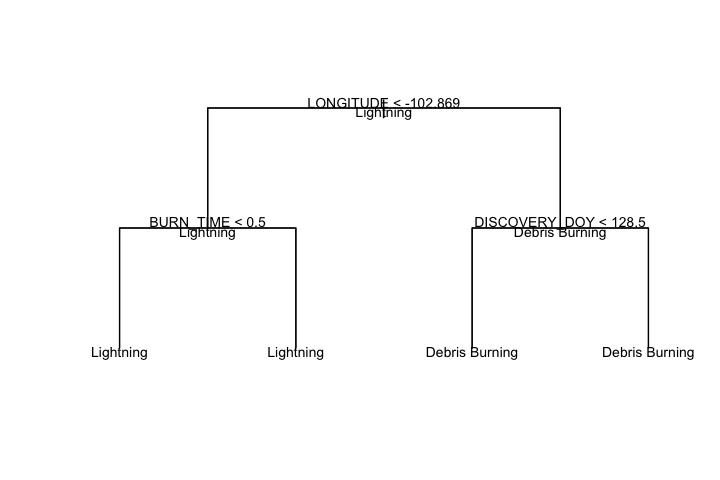

In [25]:
library(tree)
suppressMessages(library(tidymodels))

set.seed(111)
tree_fit <- tree(STAT_CAUSE_DESCR ~ ., data = train_set15)

plot(tree_fit, type = "uniform")
text(tree_fit, pretty = 1, all = TRUE, cex = 0.7)

**Fig. 7** Tree diagram with only two classes of fires `Lightning` and `Debris Burning`, for which there are four end nodes. It appears the `Longitude` is the most important predictor with there being a divide between the two predicted classes at -102.9 which roughly corresponds with the location  of the Rocky Mountains. 

In [42]:
#Make predictions on the testing set
tree_pred <- test_set15 %>% mutate(EstCODE = predict(tree_fit, test_set15, type = 'class'))

#Calculate the test error rate
print(paste("Tree misclasifcation rate:", mean(tree_pred$STAT_CAUSE_DESCR != tree_pred$EstCODE)))

[1] "Tree misclasifcation rate: 0.525920360631104"


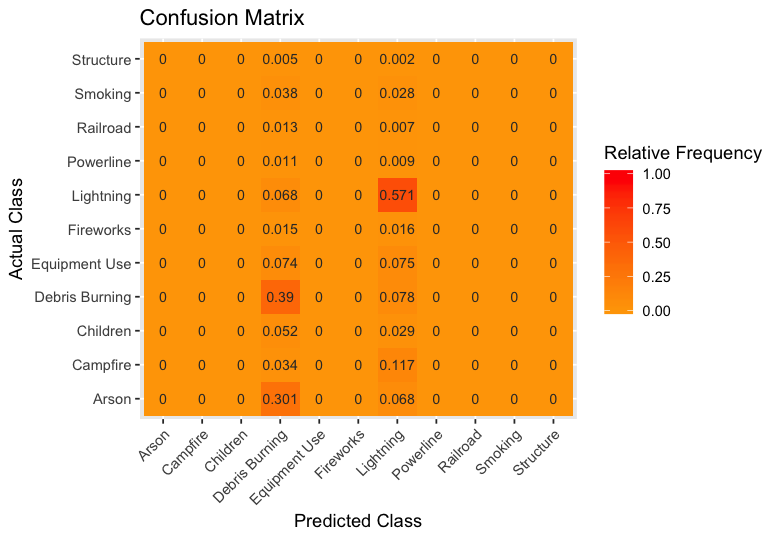

In [48]:
options(repr.plot.width=6.5, repr.plot.height=4.5, jupyter.plot_mimetypes = 'image/png')

tree_pred <- test_set15 %>% modelr::add_predictions(tree_fit, type = "class", var = 'EstCODE')
confusion_matrix(tree_pred$STAT_CAUSE_DESCR, tree_pred$EstCODE) 

In [33]:
mean(tree_pred$STAT_CAUSE_DESCR != tree_pred$EstCODE)

[1] 0.5259204

**Fig 8.** Confusion matrix for the simple tree fit. The color correpsonds to the relative frequnecy of the predicted class and the actual class. We can visually see that only `Debris Burning` and `Lightning` were predicted as causes for fires. The simple tree model had misscassification rate of ~53% which is pretty bad, lets see how it improves with other models. 

### Bagging <a class="anchor" id="bagging"></a>

Bagging for boostrap aggregation is a special case of random forest in which $m = p$ therefor we use the `randomForest` function with $m=p=6$. 

In [49]:
suppressMessages(library(randomForest))

set.seed(111)

bagging_fit <- randomForest(STAT_CAUSE_DESCR~., train_set15, mtry = 6)
bagging_pred <- test_set15 %>% mutate(EstCODE = predict(bagging_fit, test_set15, type = 'class'))

#Calculate the test error rate
print(paste("Bagging misclasifcation rate:", mean(test_set15$STAT_CAUSE_DESCR != bagging_pred$EstCODE)))

[1] 0.3908605

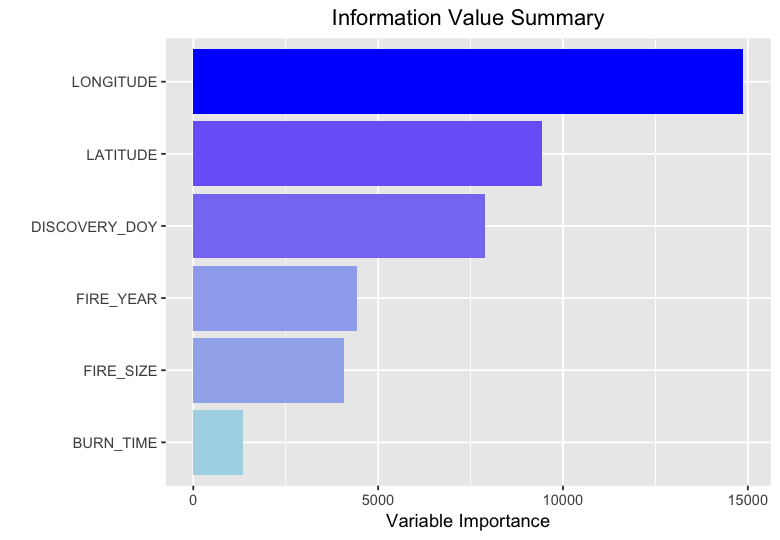

In [51]:
options(repr.plot.width=6.5, repr.plot.height=4.5, jupyter.plot_mimetypes = 'image/png')
importance_plot(fit = bagging_fit, dataset = train_set15, response = 'STAT_CAUSE_DESCR')

**Fig. 9** Variable importance plot for the Bagging model, plotted in `ggplot2`. Similar to the tree model above we see that `Longitude` is the most important predictor, followed by `Latitude`. There is more likely that not a collinear, or perphaps more complicated relationship between these two predictors which results in the mediocar glassification rate of ~40 %. A more robust methodology would be to do spatial predictions and calcualte some type of distance metric based on the `Longitude` and `Latitude`, though I am unable to do that here. 

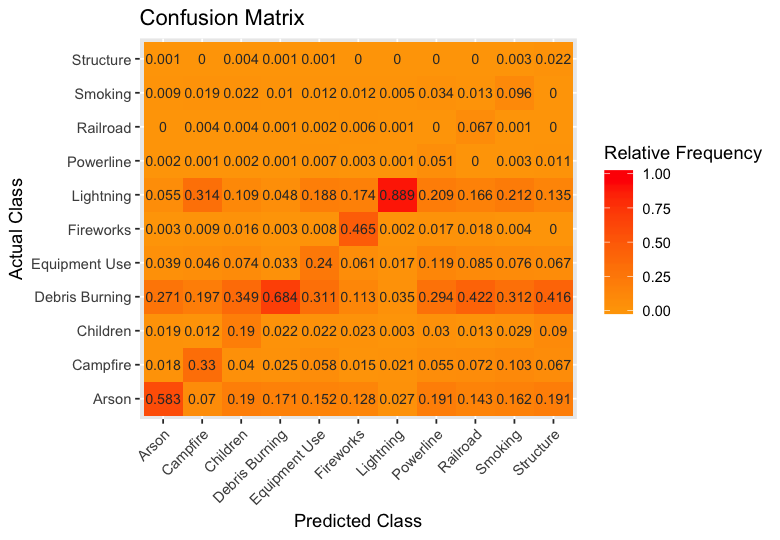

In [52]:
options(repr.plot.width=6.5, repr.plot.height=4.5, jupyter.plot_mimetypes = 'image/png')
confusion_matrix(validation = bagging_pred$STAT_CAUSE_DESCR, predicted = bagging_pred$EstCODE )

**Fig. 10** Confusion matrix for the bagging model. We cn asee that all classes were predicted this time, unlike the tree model from above. There appears to be fairly good classification in the some of the most important classes, namely `Lightning` and `Debris Burning` both of which have relative frequencies of over 0.6. Arson with a relative frequnecy of 0.58 is also a significant improvment from the previous models. It appears a thought the bagging model is able to do decent enough classifications in the classes with larger numbers of observations, but in less common classes like `Railroad` the model does a poor job of classifying the cause. 

### Random Forest <a class="anchor" id="forest"></a>

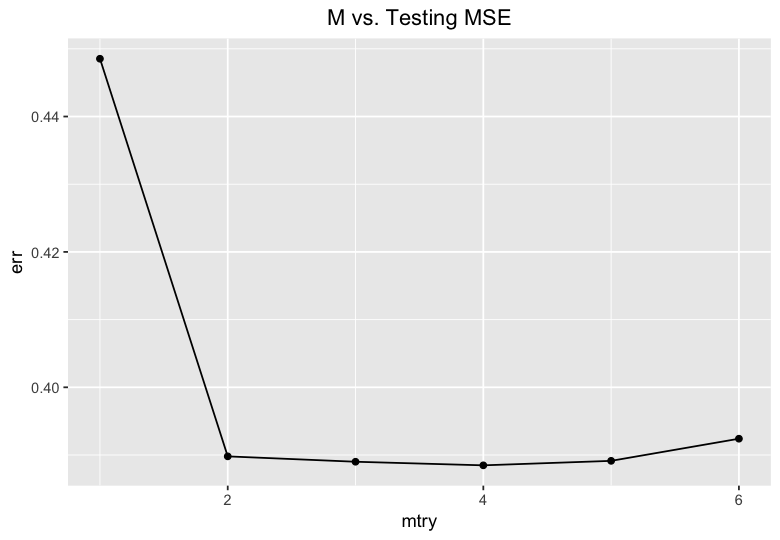

In [53]:
set.seed(111)

forest_mtry <- tibble(mtry = numeric(), err=numeric())

for (i in seq(1, 6,1)){
  rand_for_fit <- randomForest(STAT_CAUSE_DESCR ~., data = train_set15, mtry = i)
  rand_for_pred <- test_set15 %>% mutate(EstCODE = predict(rand_for_fit, test_set15, type = 'class'))
  err <- mean(rand_for_pred$STAT_CAUSE_DESCR != rand_for_pred$EstCODE)
  forest_mtry <- add_row(forest_mtry, mtry = i, err = err)
}

ggplot(forest_mtry, aes(x = mtry , y = err)) + 
  geom_point() + geom_line() + 
  ggtitle("M vs. Missclassification Rate") + theme(plot.title = element_text(hjust = 0.5))

**Fig. 11** Missclassification rate plotted versus $m$. From the plot above we see that while an $m$ of 4 mimimuizes the missclassification rate, values within the range of 2-6 are all sufficent and preform well. 

In [76]:
rand_for_fit <- randomForest(STAT_CAUSE_DESCR ~., data = train_set15, mtry = 4)

rand_for_pred <- test_set15 %>% mutate(EstCODE = predict(rand_for_fit, test_set15, type = 'class'))

#Calculate the test error rate
print(paste("Bagging misclasifcation rate:", mean(test_set15$STAT_CAUSE_DESCR != rand_for_pred$EstCODE), "%"))

[1] "Bagging misclasifcation rate: 0.388650727007557 %"


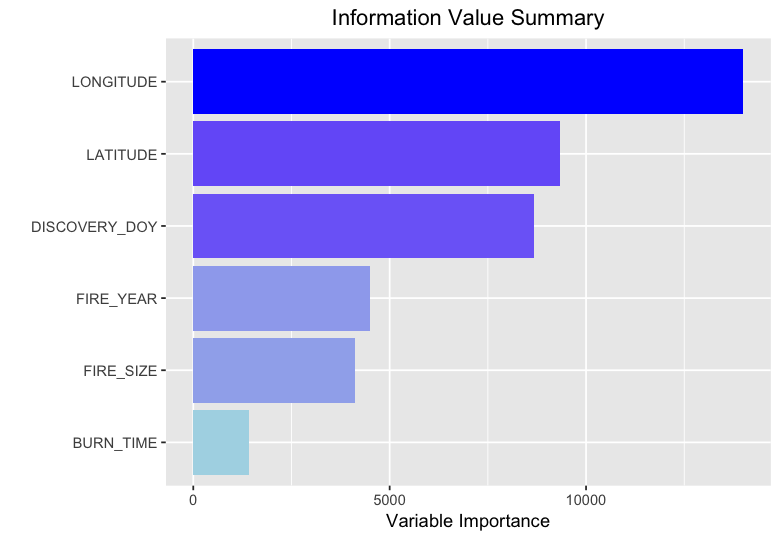

In [77]:
importance_plot(fit = rand_for_fit, dataset = train_set15, response = 'STAT_CAUSE_DESCR')

**Figl. 12** Variable importance for the random forest model with $m$ = 4. Like the simple tree and bagging models above, `Longitude` and `Latitude` are the most important predictors. The implications for bias in our predictions is disscussed above. 

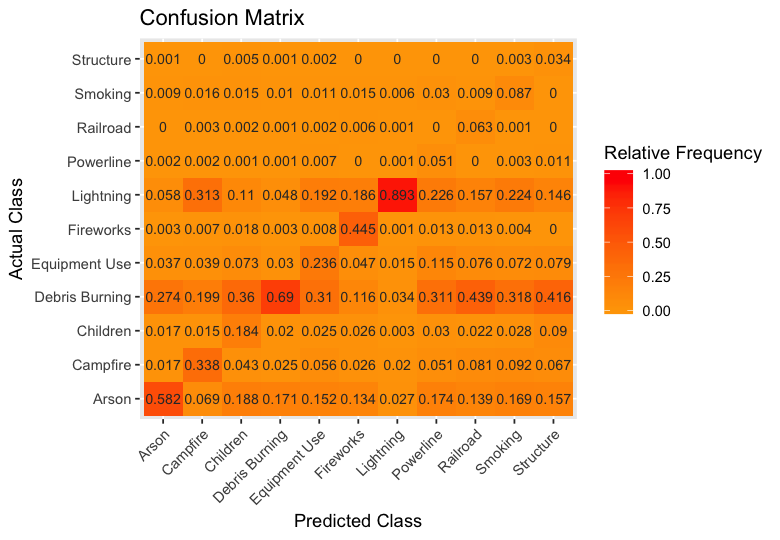

In [78]:
confusion_matrix(validation = rand_for_pred$STAT_CAUSE_DESCR, predicted = rand_for_pred$EstCODE )

**Fig. 13** Confusion matrix for the random forest model with $m$ = 4. There appears the a slight improvment in the missclassification rate on the testing set with random forest model as compared to the bagging model, though the difference is only ~1%. Simiarly to the bagging model above, the random forest does a good job classifying `Lightning`, `Debris Burnign`, and to some extent `Arson` while it has trouble with less commone classes such as `Railroad` or `Smoking`.

### Boosting <a class="anchor" id="boosting"></a>

[1] "Test error using boosting = 0.9132894329783"


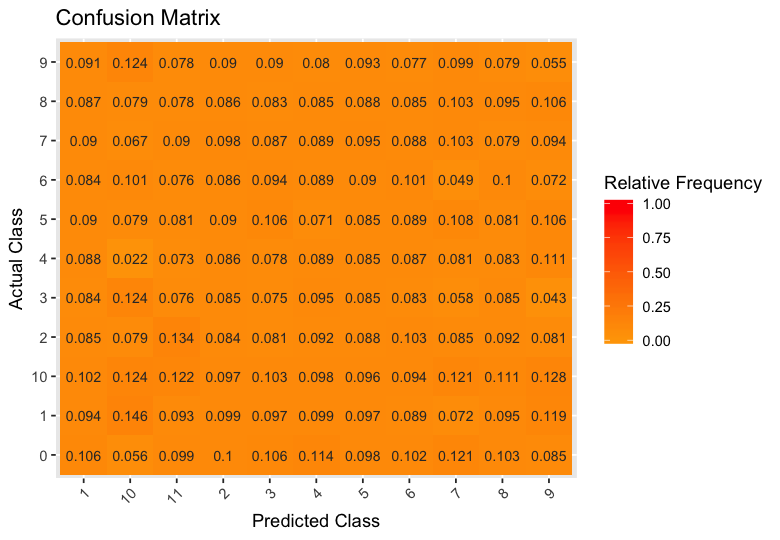

In [81]:
set.seed(111)
suppressMessages(library(gbm))

boost_fit <- gbm(STAT_CAUSE_DESCR ~ ., data= train_set15, n.tree = 100, distribution = 'multinomial', n.cores = 4)

boost_pred <- predict(boost_fit, test_set15, n.trees = 100, type = 'response') %>% matrix(., ncol = 11, byrow = TRUE) %>% apply(., 1, which.max) - 1L 

print(paste("Test error using boosting =", mean(boost_pred !=  test_set15$STAT_CAUSE_DESCR %>% as.numeric())))

confusion_matrix(predicted = boost_pred, validation = test_set15$STAT_CAUSE_DESCR %>% as.numeric())


**Fig. 14** Confusion Matrix for the boosting model with a missclassification rate of < 90%. I am unsure as to why the missclassification rate is so high for this model, there may be an error in its implementation. 

### Extereme Gradient Boosting <a class="anchor" id="xgboost"></a>  

<!-- [xgboost multiclass](https://github.com/dmlc/xgboost/blob/master/demo/multiclass_classification/train.R) --> 

<!-- [xgboost multiclass 2](https://www.analyticskhabar.com/multiclass-classification-with-xgboost-in-r/) -->

<!-- [xgboost vs boosting vs ...](https://www.kaggle.com/nschneider/gbm-vs-xgboost-vs-lightgbm#Results) --> 

[1]	train-merror:0.419802	test-merror:0.433951 
[2]	train-merror:0.409194	test-merror:0.426614 
[3]	train-merror:0.402811	test-merror:0.422592 
[4]	train-merror:0.399875	test-merror:0.420515 
[5]	train-merror:0.396844	test-merror:0.417952 
[6]	train-merror:0.395140	test-merror:0.416891 
[7]	train-merror:0.393018	test-merror:0.416096 
[8]	train-merror:0.390556	test-merror:0.415742 
[9]	train-merror:0.388415	test-merror:0.414726 
[10]	train-merror:0.384968	test-merror:0.412383 
[11]	train-merror:0.382865	test-merror:0.410837 
[12]	train-merror:0.380952	test-merror:0.409599 
[13]	train-merror:0.378698	test-merror:0.408406 
[14]	train-merror:0.377410	test-merror:0.408715 
[15]	train-merror:0.375099	test-merror:0.407257 
[16]	train-merror:0.373982	test-merror:0.407434 
[17]	train-merror:0.372978	test-merror:0.406903 
[18]	train-merror:0.371008	test-merror:0.406285 
[19]	train-merror:0.369436	test-merror:0.405798 
[20]	train-merror:0.366936	test-merror:0.404649 
[21]	train-merror:0.365269	te

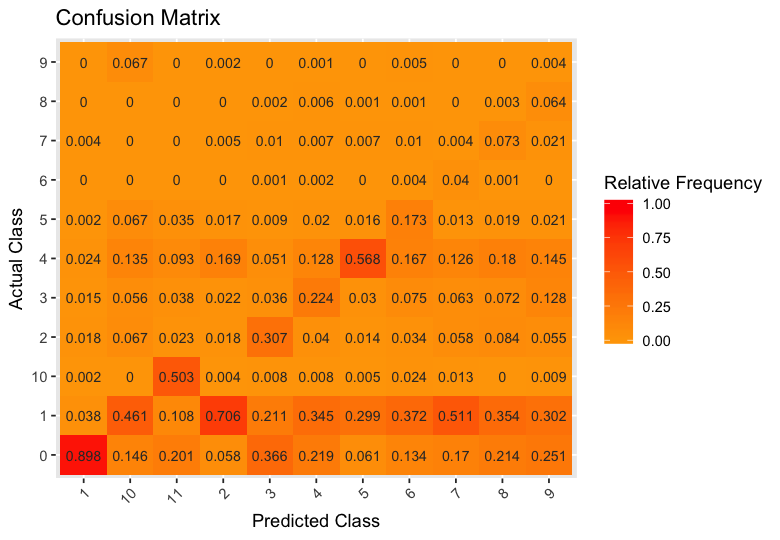

In [56]:
set.seed(111)
suppressMessages(library(xgboost))

xg_train <- xgb.DMatrix(data = as.matrix(train_set15 %>% select(-STAT_CAUSE_DESCR)), label = train_set15$STAT_CAUSE_DESCR %>% as.numeric() - 1L)

xg_test <- xgb.DMatrix(data = as.matrix(test_set15 %>% select(-STAT_CAUSE_DESCR)), label = test_set15$STAT_CAUSE_DESCR %>% as.numeric() - 1L)

params <- list(
  objective = 'multi:softmax',
  num_class = 13,
  nthread = 4
)

watchlist = list(train = xg_train, test = xg_test)

xgboost_fit <- xgb.train(
  params = params,
  data = xg_train,
  watchlist = watchlist,
  nrounds = 100
)

pred <- predict(xgboost_fit, xg_test)
error_rate <- sum(pred != test_set15$STAT_CAUSE_DESCR %>% as.numeric() - 1L) / length(test_set15$STAT_CAUSE_DESCR %>% as.numeric())
print(paste("Test error using softmax =", error_rate))

confusion_matrix(predicted = pred, validation = test_set15$STAT_CAUSE_DESCR %>% as.numeric())

**Fig. 15** Confusion Matrix for the xtreme gradient Boosting model from `xgboost`. The missclassification rate of ~38% is on par with the results from random forest and repesent our best values yet in this study. 

In [73]:
# This stopped working for me for some reason, there is no longer a `Importance` variable in tibble returned
# by the `xgb.importance` call. 

imp = xgb.importance(model = xgboost_fit)

bagging_import <- tibble(
  var = train_set15 %>% select(-STAT_CAUSE_DESCR) %>% names(), 
  import = c(imp$Importance))

  ggplot(bagging_import, aes(x = reorder(var, import), y = import, fill = import)) +
    geom_bar(stat="identity", position="dodge")+ coord_flip() +
    ylab("Variable Importance")+
    xlab("") +
    guides(fill=F) +
    ggtitle("Information Value Summary")+
    scale_fill_continuous(low="lightblue", high="blue") + theme(plot.title = element_text(hjust = 0.5))

ERROR: All columns in a tibble must be 1d or 2d objects:
* Column `import` is NULL

### Support Vector Machines  <a class="anchor" id="SVM"></a>

[1] 0.4338622

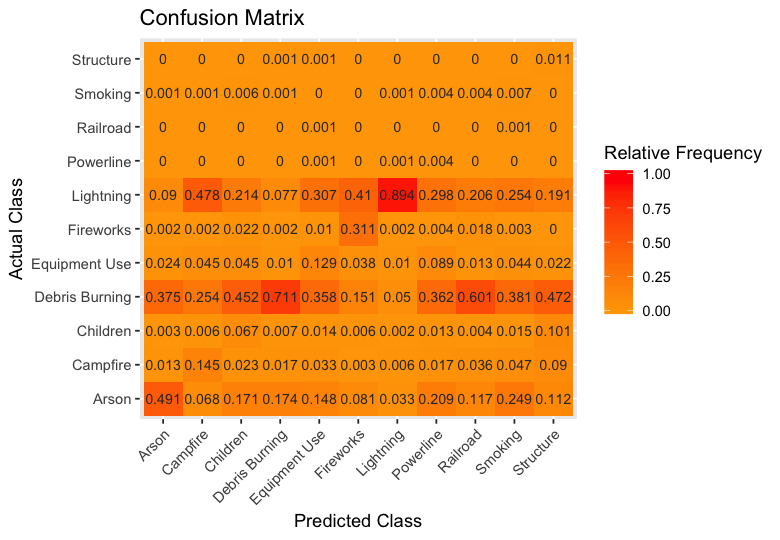

In [82]:
suppressMessages(library(e1071))

svm_fit <- svm(STAT_CAUSE_DESCR ~ ., train_set15, kernel = "radial", cost = 10, gamma = 1)

svm_predict <- test_set15 %>% mutate(EstCODE = predict(svm_fit, test_set15))

mean(svm_predict$EstCODE != svm_predict$STAT_CAUSE_DESCR)

confusion_matrix(predicted = svm_predict$EstCODE, validation = svm_predict$STAT_CAUSE_DESCR)

**Fig.** Confusion matrix from the support vecotr machine model with a missclassification rate of 43 %. Like previous model the `SVM` does an alright job classifying the large classes such as `Lightning`, `Debris Burning`, and `Arson` while preforming poorly on the less common classes. 

## Disscusion / Conclusions <a class="anchor" id="wrap_up"></a>

Here we have used a dataset provided by the U.S. Forest Service hosted on [Kaggle](https://www.kaggle.com/rtatman/188-million-us-wildfires) to try and predict the cause of a wildfire based on it's location, seasonality, size, and burn time. The original database contained 1.88 million records, but after data cleaning we subseted the data to a chunk of ~80,000 observations. We then split the data set into training and testing sets (70/30) which were used to fit our models. For our multiclass classification analysis we used tree, baggin, random forest, gradeint boosting, extereme gradient boosting, and support vector machines. Random forest with $m$ = 4 and extreme gradient boosting results in the best missclassification rates of ~38%. We consitently between all the models an ability to predict with relative accuracy the cause of wildfire if it fall into one of the large classes such as `Lightning`, `Debris Burning`, or `Arson`, and inability from any of the models to accurately predict the less frequent classses such as `Campfire`, `Children`, or `Railroad`. In order to obtain better classification rates it may useful in the future to generate a training set that contains roughly equal protions of all the cause classes insteas of randomly generating one and not controlling for it. Multiple of the models used above identified `Longitude` and `Lattitude` to be the most important predicors in the respective models. This represent a major flaw in our anaylsis since we treated `Longitude` and `Lattitude` as numeric values and did not account for any linear or more complex relationship between the two variables. Implementation of some basic spatial anlysis techniques would help to adress these flaws in the analysis.   

In order to generate a more accurate, and therefore more useful multiclass classfication model we need:  
- to be able to process more the actual dataset wihtout having to downsample  
- create a more representative trainset with an equal distribution of all the classes, instead of one biased by more frequent classes  
- implement spatial analysis methods to deal with the spatial domain of this problem  
- more fine tunning of paramters in the choosen models to be able to mimize missclassification rates 
- explor more complex models such as nueral networks 

The analysis presented here represent an inital step in a much longer and more complicated picture. If what was set out do here was acutally able to be done in a reprodubale and scalable manner, it would have signifcant impact in the modern world. 